In [1]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Cargamos el archivo CSV (https://www.kaggle.com/datasets/rodrigoccfernandes/sncf-tgv-international-travels-delay)
df = pd.read_csv('regularite-mensuelle-tgv-aqst.csv', sep=';')

# Juntamos todas las estaciones de Paris
df['Gare de départ'] = df['Gare de départ'].str.replace(r'PARIS\b.*', 'PARIS', regex=True)
df["Gare d'arrivée"] = df["Gare d'arrivée"].str.replace(r'PARIS\b.*', 'PARIS', regex=True)

# Nos quedamos solo con los viajes que salen o llegan a Paris
df_filtered = df[(df['Gare de départ'] == 'PARIS') | (df["Gare d'arrivée"] == 'PARIS')]

# Apilamos ambas columnas en una nueva columna única y eliminamos duplicados, así tenemos una lista completa
ciudades = pd.concat([df_filtered['Gare de départ'], df_filtered["Gare d'arrivée"]]).drop_duplicates().reset_index(drop=True).tolist()
ciudades.remove('ITALIE') # Eliminamos Italia, ya que no es una ciudad
ciudades_df = pd.DataFrame(ciudades, columns=['Ciudad'])

# Configuramos el geocodificador
geolocator = Nominatim(user_agent="locationExercise")

# Función para obtener las coordenadas de las ciudades
def obtener_coordenadas(ciudad):
    try:
        location = geolocator.geocode(ciudad)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return None, None

# Aplicamos la función para obtener las coordenadas de cada ciudad
ciudades_df[['Latitud', 'Longitud']] = ciudades_df['Ciudad'].apply(lambda x: pd.Series(obtener_coordenadas(x)))

print(ciudades_df.head())
print(ciudades_df.tail())

                Ciudad    Latitud  Longitud
0     BORDEAUX ST JEAN  44.825659 -0.555587
1    LA ROCHELLE VILLE  46.152577 -1.145306
2                PARIS  48.858890  2.320041
3              QUIMPER  47.996032 -4.102478
4  ST PIERRE DES CORPS  47.389815  0.718976
                            Ciudad    Latitud  Longitud
46             AIX EN PROVENCE TGV  43.455145  5.317287
47                     DIJON VILLE  47.323045  5.027254
48  LE CREUSOT MONTCEAU MONTCHANIN  46.765315  4.499502
49                  LYON PART DIEU  45.760564  4.859533
50            MARSEILLE ST CHARLES  43.303263  5.381193


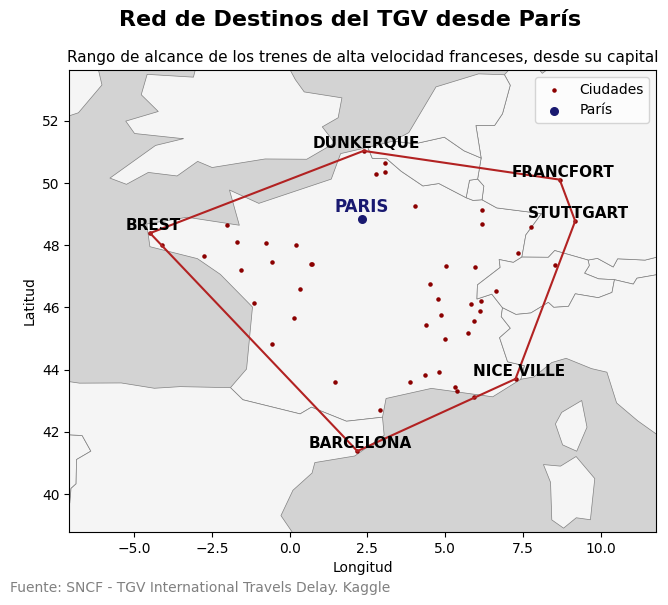

In [13]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Extraemos las coordenadas para el convex hull
puntos = ciudades_df[['Latitud', 'Longitud']].values

# Calculamos el convex hull
hull = ConvexHull(puntos)

# Creamos un objeto GeoDataFrame para las ciudades (puntos)
geometry = [Point(lon, lat) for lat, lon in puntos]
gdf_ciudades = gpd.GeoDataFrame(ciudades_df, geometry=geometry)

# Cargamos el mapa base
mundo = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Limites para que se amplie el mapa, y solo se muestre lo que nos interesa
lat_min, lat_max = puntos[:, 0].min()-2.5, puntos[:, 0].max()+2.5
lon_min, lon_max = puntos[:, 1].min()-2.5, puntos[:, 1].max()+2.5

# Graficamos el mapa base
fig, ax = plt.subplots(figsize=(10, 6))

# Formateamos los colores del mapa
mundo.plot(ax=ax, color='whitesmoke', edgecolor='gray', linewidth=0.5)  # Países en gris claro con borde mas oscuro
ax.set_facecolor('lightgray')  # Mar en gris

# Añadimos los puntos de las ciudades en rojo oscuro
gdf_ciudades.plot(ax=ax, marker='o', color='darkred', markersize=5, label='Ciudades')

# Dibujamos el convex hull
for simplex in hull.simplices:
    plt.plot(puntos[simplex, 1], puntos[simplex, 0], 'firebrick', linestyle='-', linewidth=1.5)

# Identificamos cuáles son los vértices del convex hull y añadimos los nombres de esas ciudades
hull_vertices = puntos[hull.vertices]
for i, vertex in enumerate(hull_vertices):
    ciudad = ciudades_df.iloc[hull.vertices[i]]['Ciudad']
    plt.text(vertex[1] + 0.1, vertex[0] + 0.1, ciudad, fontsize=11, ha='center', color='black', fontweight='bold')

# Resaltamos París
paris_index = ciudades_df[ciudades_df['Ciudad'] == 'PARIS'].index[0]
paris_point = puntos[paris_index]
plt.scatter(paris_point[1], paris_point[0], color='midnightblue', s=30, label='París', zorder=6)  # París más grande y en azul oscuro
plt.text(paris_point[1], paris_point[0]+ 0.2, "PARIS", fontsize=12, ha='center', color='midnightblue', fontweight='bold') #Marcamos tmb el nombre de París

# Establecemos los límites del plot basados en los limites calculados antes
ax.set_xlim(lon_min - 0.1, lon_max + 0.1)
ax.set_ylim(lat_min - 0.1, lat_max + 0.1)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.suptitle("Red de Destinos del TGV desde París", fontsize=16, fontweight='bold')
plt.title("Rango de alcance de los trenes de alta velocidad franceses, desde su capital", fontsize=11)
plt.figtext(0.35, 0.01, "Fuente: SNCF - TGV International Travels Delay. Kaggle (2022)", ha="center", fontsize=10, color="gray")

plt.legend()
plt.show()